# Support Center Queue

Jill manages a software support center.  Jill wants to run an analysis on how long support requests remain in the system before getting resolved.  Collecting some stats and showing a Histogram of request time in system seems like a nice outcome.  Jill has data of when each request enters the system, and when each request is resolved.  

One methodology is to gather various Scenarios for which to analyze.  For example, a Busy Post Launch Scenario, a Mild Scenario,  A Monday Morning Scenario, etc.   And then use these scenarios to plan staffing, etc.

To test her methodology and code, she will use the following small dataset and make the following assumptions:

- Jobs arrive, are processed, and complete only at integral units of minutes
- Request arrival times:  `0, 5, 10, 12, 14, 15, 55`
- So, the time between arrivals is `5, 5, 2, 2, 1, 40`
- Service times for each request, that is, time to resolve once started: `4, 4, 10, 10, 10, 10, 1`
- There is a single support staff that processes requests First-In-First-Out (FIFO)

In [20]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from Stats import Entity, Resource, Source
from pprint import pprint

In [21]:
def dispose(entity):
    return lambda _: entity.dispose() 

def process(env, source, resource):
    """ Generate arrivals into our simulation
    
    Arguments:   
     env:  Our simulation environment
     source: the source of entities for our simulation
     resource: Shared resource
    """
    
    for arrival_time, entity in source.next_entity():
        yield arrival_time
        processed_entity = env.process(resource.process_entity(entity))
        processed_entity.callbacks.append(dispose(entity))
                

In [22]:
class CallCenter(Resource):
    def __init__(self, env, *args, **kwargs):
        self.name = "call_center"
        self.env = env
        super().__init__(env, *args, **kwargs) # still looks scary
        
    def process_entity(self, entity):
        request = entity.request_resource(self)
        print(f'{entity.name} requesting resource: {self.env.now}')
        yield request
        
        print(f'{entity.name} started processing: {self.env.now}')        
        entity.start_service_at_resource(self)
        yield self.env.timeout(self.next_service_time())
        
        print(f'{entity.name} finished: {self.env.now}')
        entity.release_resource(self, request)
        return entity
    
    def service_time_generator(self):
        service_times = [4,4,10,10,10,10,1]
        for time in service_times:
            yield time  
    

In [23]:
class JobSource(Source):
    def __init__(self, env, *args, **kwargs):
        self.name="job_source"
        self.env = env
        super().__init__(env, *args, **kwargs)
    
    def interarrival_time_generator(self):
        interarrival_times = [5,5,2,2,1,40]
        for time in interarrival_times:
            yield time
    
    def build_entity(self, creation_time, *args, **kwargs):
        return Entity(self.env, f"job_{len(self.entities)}", creation_time, *args, **kwargs)
         
        

In [24]:
# Setup and start the simulation
print('Support Center 1\n')
env = simpy.Environment()

source = JobSource(env, first_creation=0)
# Start processes and run
resource = CallCenter(env, capacity=1)

env.process(process(env, source, resource))
env.run()

Support Center 1

job_0 requesting resource: 0
job_0 started processing: 0
job_0 finished: 4
job_0 disposed: 4
job_1 requesting resource: 5
job_1 started processing: 5
job_1 finished: 9
job_1 disposed: 9
job_2 requesting resource: 10
job_2 started processing: 10
job_3 requesting resource: 12
job_4 requesting resource: 14
job_5 requesting resource: 15
job_2 finished: 20
job_2 disposed: 20
job_3 started processing: 20
job_3 finished: 30
job_3 disposed: 30
job_4 started processing: 30
job_4 finished: 40
job_4 disposed: 40
job_5 started processing: 40
job_5 finished: 50
job_5 disposed: 50
job_6 requesting resource: 55
job_6 started processing: 55
job_6 finished: 56
job_6 disposed: 56


In [25]:
"""
Statistics collected by entities that passed through system
"""
system_time = source.get_total_times()
print("total_time:", source.get_total_times())
print("waiting_time:", source.get_waiting_times())
print("processing_time:", source.get_processing_times())

total_time: [4, 4, 10, 18, 26, 35, 1]
waiting_time: [0, 0, 0, 8, 16, 25, 0]
processing_time: [4, 4, 10, 10, 10, 10, 1]


In [7]:
"""
Statistics collected by resource
"""
queue_over_time = resource.queue_size_over_time() # sample queue length
print(queue_over_time)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
print('The average system time is:',np.mean(system_time))

The average system time is: 14.0


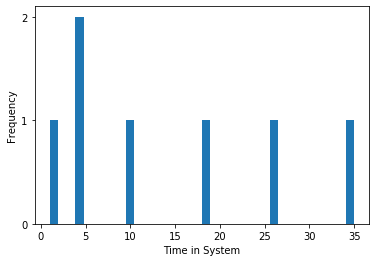

In [9]:
# Tinker with number of bins, until it looks right
plt.hist(system_time,bins=36)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

## The NumPy package provides lots of statistical methods, we call it with `np`

Average number in queue: 0.875


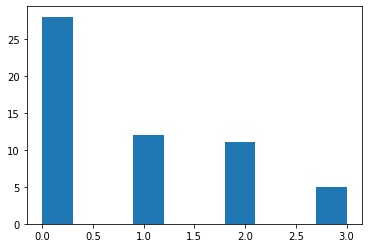

In [10]:
"""
Histogram of queue over time
"""
plt.hist(queue_over_time)
print(f"Average number in queue: {np.mean(queue_over_time)}")

In [11]:
np.max(system_time)

35

In [12]:
# 50th percentile, or median
np.percentile(system_time,50)

10.0

In [13]:
np.median(system_time)

10.0

In [14]:
np.std(system_time)

11.868325191750639

# Support Center: Homework/Class work

Add to this notebook to answer the following:

1. Consider the number of jobs in the queue over time, from 0 until all jobs are completed
  - What is the average number of jobs in the queue?
  - Form a histogram of the number of jobs in the queue

1. Consider the time jobs spend in the queue, before beginning service.
  - What is the average time a job spends in the queue?
  - Form a histogram of the time jobs spend in the queue
  
